## Using Marbert Embeddings

In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")
model = AutoModelForMaskedLM.from_pretrained("UBC-NLP/MARBERT")


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
import random

np.random.seed(777)
tf.random.set_seed(777)
random.seed(777)

In [9]:
df = pd.read_csv('Data/App Reviews-Multilabel.csv')


print(f"Dataset shape: {df.shape}")
print("\nSample data:")
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
print(df.describe(include='all'))

Dataset shape: (2900, 5)

Sample data:
                                              review  bug_report  \
0                                 يبيله تصليحات كثير           1   
1                  ماتحملت ابدددددا ونا دفعت فلوس 🤔😕           0   
2  اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...           0   
3      ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت           0   
4                                تبين م لي ي تم ل يب           0   

   improvement_request  rating  others  
0                    1       1       0  
1                    1       1       1  
2                    1       1       0  
3                    0       1       0  
4                    0       1       1  

Missing values:
review                 0
bug_report             0
improvement_request    0
rating                 0
others                 0
dtype: int64

Basic statistics:
                 review   bug_report  improvement_request       rating  \
count              2900  2900.000000          2900.000000 

## Analysis

Label distribution (number of samples where label = 1):
rating                 1971
bug_report             1164
improvement_request    1103
others                  820
dtype: int64

Label percentages:
rating                 67.97
bug_report             40.14
improvement_request    38.03
others                 28.28
dtype: float64


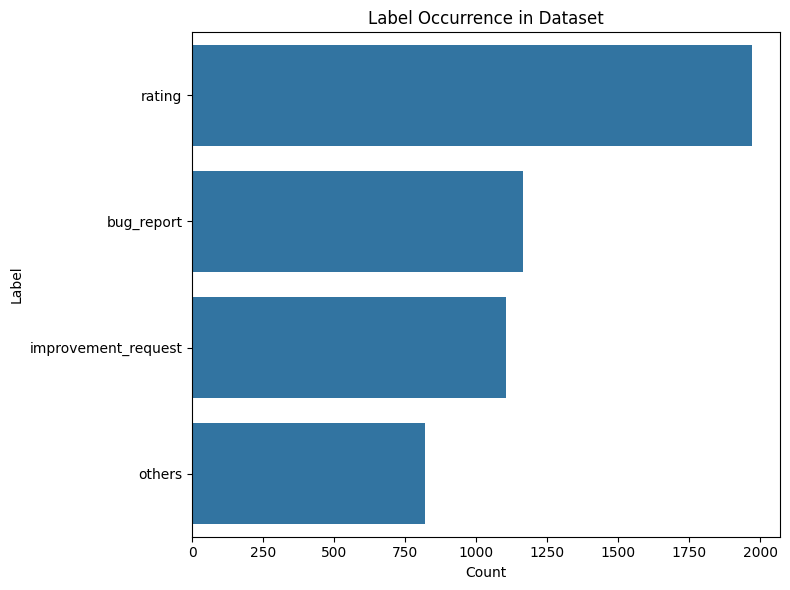

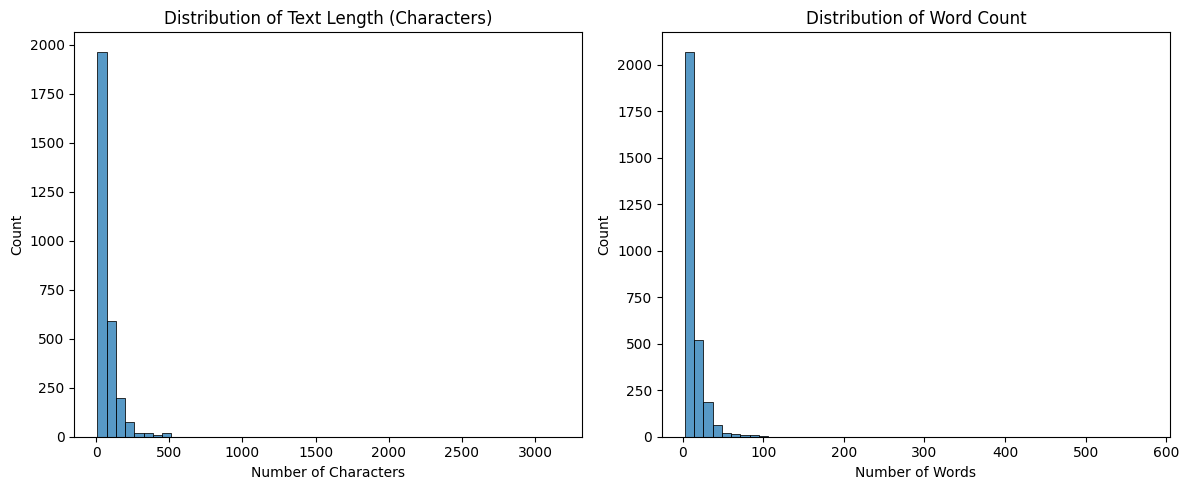


📊 Text length stats for label: 'bug_report'
             count       mean         std   min   25%   50%    75%     max
bug_report                                                                
0           1736.0  68.113479  100.145418  10.0  30.0  45.0   75.0  3166.0
1           1164.0  84.134880   67.613742  13.0  41.0  64.5  103.0   500.0

📊 Word count stats for label: 'bug_report'
             count       mean        std  min  25%   50%   75%    max
bug_report                                                           
0           1736.0  12.178571  17.693266  3.0  6.0   8.0  13.0  576.0
1           1164.0  15.599656  12.401614  3.0  8.0  12.0  19.0   99.0

📊 Text length stats for label: 'improvement_request'
                      count       mean        std   min   25%   50%    75%  \
improvement_request                                                          
0                    1797.0  66.489149  94.841449  10.0  30.0  46.0   75.0   
1                    1103.0  87.667271  76.

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

label_cols = ['bug_report', 'improvement_request', 'rating', 'others']

# ✅ Count of label presence per column
label_counts = df[label_cols].sum().sort_values(ascending=False)

print("Label distribution (number of samples where label = 1):")
print(label_counts)

print("\nLabel percentages:")
print(round((label_counts / len(df)) * 100, 2))

# ✅ Plot label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.values, y=label_counts.index)
plt.title('Label Occurrence in Dataset')
plt.xlabel('Count')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

# ✅ Text statistics
df['text_length'] = df['review'].astype(str).apply(len)
df['word_count'] = df['review'].astype(str).apply(lambda x: len(x.split()))

# ✅ Plot text length and word count distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['text_length'], bins=50)
plt.title('Distribution of Text Length (Characters)')
plt.xlabel('Number of Characters')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], bins=50)
plt.title('Distribution of Word Count')
plt.xlabel('Number of Words')

plt.tight_layout()
plt.show()

# ✅ Length statistics per label presence
for col in label_cols:
    print(f"\n📊 Text length stats for label: '{col}'")
    print(df.groupby(col)['text_length'].describe())

    print(f"\n📊 Word count stats for label: '{col}'")
    print(df.groupby(col)['word_count'].describe())


## Preprocessing


In [11]:
def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df['processed_text'] = df['review'].apply(preprocess_text)

print("Original vs Processed Text Examples:")
for i in range(3):
    print(f"Original: {df['review'].iloc[i]}")
    print(f"Processed: {df['processed_text'].iloc[i]}")
    print()

Original vs Processed Text Examples:
Original: يبيله تصليحات كثير
Processed: يبيله تصليحات كثير

Original: ماتحملت ابدددددا ونا دفعت فلوس 🤔😕
Processed: ماتحملت ابدددددا ونا دفعت فلوس

Original: اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوضاً عن تفضيل الحلقات فقط
وشكراً
Processed: اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوضا عن تفضيل الحلقات فقط وشكرا



# Data split

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

# Inputs and labels
X = df['processed_text'].values
y = df[['bug_report', 'improvement_request', 'rating', 'others']].values  # shape: [n_samples, 4]

# Manual shuffle
np.random.seed(777)
indices = np.arange(len(X))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

# Split proportions
n_total = len(X)
n_test = int(0.2 * n_total)
n_val = int(0.15 * n_total)

X_train_val, X_test = X[:n_total - n_test], X[n_total - n_test:]
y_train_val, y_test = y[:n_total - n_test], y[n_total - n_test:]

X_train, X_val = X_train_val[:-n_val], X_train_val[-n_val:]
y_train, y_val = y_train_val[:-n_val], y_train_val[-n_val:]

# Print sizes
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Print label distribution
def print_label_distribution(name, y_subset):
    print(f"\n{name} set label distribution (count of 1s):")
    label_cols = ['bug_report', 'improvement_request', 'rating', 'others']
    df_subset = pd.DataFrame(y_subset, columns=label_cols)
    print(df_subset.sum())

print_label_distribution("Train", y_train)
print_label_distribution("Validation", y_val)
print_label_distribution("Test", y_test)


Train set size: 1885
Validation set size: 435
Test set size: 580

Train set label distribution (count of 1s):
bug_report              757
improvement_request     740
rating                 1273
others                  520
dtype: int64

Validation set label distribution (count of 1s):
bug_report             162
improvement_request    147
rating                 303
others                 146
dtype: int64

Test set label distribution (count of 1s):
bug_report             245
improvement_request    216
rating                 395
others                 154
dtype: int64


## Tokenizer

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")

def tokenize_texts(texts, max_length=128):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize each split
tokenized_train = tokenize_texts(X_train)
tokenized_val = tokenize_texts(X_val)
tokenized_test = tokenize_texts(X_test)


## Dataset Class

In [14]:
from torch.utils.data import Dataset
import torch

class ArabicMultiLabelDataset(Dataset):
    def __init__(self, tokenized_data, labels):
        self.input_ids = tokenized_data["input_ids"]
        self.attention_mask = tokenized_data["attention_mask"]
        self.labels = torch.tensor(labels, dtype=torch.float32)  # shape: [N, 4]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }


## Dataloader

In [15]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataset = ArabicMultiLabelDataset(tokenized_train, y_train)
val_dataset = ArabicMultiLabelDataset(tokenized_val, y_val)
test_dataset = ArabicMultiLabelDataset(tokenized_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


## Bidirectional GRU Model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModel
from tqdm import tqdm

class BiGRUMultiLabelModel(nn.Module):
    def __init__(self, hidden_dim=128, num_labels=4):
        super().__init__()
        self.marbert = AutoModel.from_pretrained("UBC-NLP/MARBERT")
        embedding_dim = self.marbert.config.hidden_size  # 768

        for param in self.marbert.parameters():
            param.requires_grad = False  # freeze MARBERT

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            bidirectional=True,
            batch_first=True
        )

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            embeddings = self.marbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        rnn_out, _ = self.gru(embeddings)
        pooled = torch.mean(rnn_out, dim=1)
        logits = self.fc(self.dropout(pooled))
        return logits




In [25]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        print(f"\n🔁 Epoch {epoch + 1}/{num_epochs}")

        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"✅ Avg training loss: {avg_train_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"🔍 Avg validation loss: {avg_val_loss:.4f}")


In [26]:
def save_model(model, path="bigru_fc_only.pt"):
    trainable_state_dict = {
        k: v for k, v in model.state_dict().items()
        if k.startswith("gru") or k.startswith("fc")
    }
    torch.save(trainable_state_dict, path)


In [27]:
def load_model(path="bigru_fc_only.pt", device=None):
    model = BiGRUMultiLabelModel()
    saved_state = torch.load(path, map_location=device or "cpu")

    full_state = model.state_dict()
    full_state.update(saved_state)
    model.load_state_dict(full_state)

    if device:
        model.to(device)
    model.eval()
    return model

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiGRUMultiLabelModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train
train_model(model, train_loader, val_loader, optimizer, device, num_epochs=5)


🔁 Epoch 1/5


Training: 100%|██████████| 118/118 [02:14<00:00,  1.14s/it]


✅ Avg training loss: 0.5663


Validating: 100%|██████████| 28/28 [00:26<00:00,  1.06it/s]


🔍 Avg validation loss: 0.4881

🔁 Epoch 2/5


Training: 100%|██████████| 118/118 [02:14<00:00,  1.14s/it]


✅ Avg training loss: 0.4569


Validating: 100%|██████████| 28/28 [00:26<00:00,  1.07it/s]


🔍 Avg validation loss: 0.4394

🔁 Epoch 3/5


Training: 100%|██████████| 118/118 [02:17<00:00,  1.16s/it]


✅ Avg training loss: 0.4175


Validating: 100%|██████████| 28/28 [00:26<00:00,  1.05it/s]


🔍 Avg validation loss: 0.4281

🔁 Epoch 4/5


Training: 100%|██████████| 118/118 [02:18<00:00,  1.17s/it]


✅ Avg training loss: 0.3980


Validating: 100%|██████████| 28/28 [00:26<00:00,  1.04it/s]


🔍 Avg validation loss: 0.4276

🔁 Epoch 5/5


Training: 100%|██████████| 118/118 [02:20<00:00,  1.19s/it]


✅ Avg training loss: 0.3863


Validating: 100%|██████████| 28/28 [00:27<00:00,  1.02it/s]

🔍 Avg validation loss: 0.4187


In [29]:
# Save only GRU/FC weights
save_model(model, "bigru_fc_only.pt")


## Evaluation

In [30]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
import torch

def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            all_labels.append(labels)
            all_preds.append(preds)

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    print("📊 Classification Report (per label):")
    print(classification_report(all_labels, all_preds, target_names=label_cols, zero_division=0))

    print("🔍 Macro F1:", f1_score(all_labels, all_preds, average='macro'))
    print("🔍 Micro F1:", f1_score(all_labels, all_preds, average='micro'))


In [31]:
evaluate_model(model, test_loader)


📊 Classification Report (per label):
                     precision    recall  f1-score   support

         bug_report       0.82      0.79      0.80       245
improvement_request       0.79      0.58      0.67       216
             rating       0.93      0.82      0.87       395
             others       0.67      0.57      0.62       154

          micro avg       0.84      0.72      0.78      1010
          macro avg       0.80      0.69      0.74      1010
       weighted avg       0.83      0.72      0.77      1010
        samples avg       0.87      0.79      0.80      1010

🔍 Macro F1: 0.7408389562025618
🔍 Micro F1: 0.7755968169761274


In [32]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_confusion_matrices(model, dataloader, threshold=0.5, label_names=None):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            all_labels.append(labels)
            all_preds.append(preds)

    y_true = np.vstack(all_labels)
    y_pred = np.vstack(all_preds)

    # Confusion matrices for each label
    cm_per_label = multilabel_confusion_matrix(y_true, y_pred)

    fig, axes = plt.subplots(1, len(label_names), figsize=(18, 4))
    for i, (cm, label) in enumerate(zip(cm_per_label, label_names)):
        ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(ax=axes[i], values_format='d')
        axes[i].set_title(label)

    plt.tight_layout()
    plt.show()


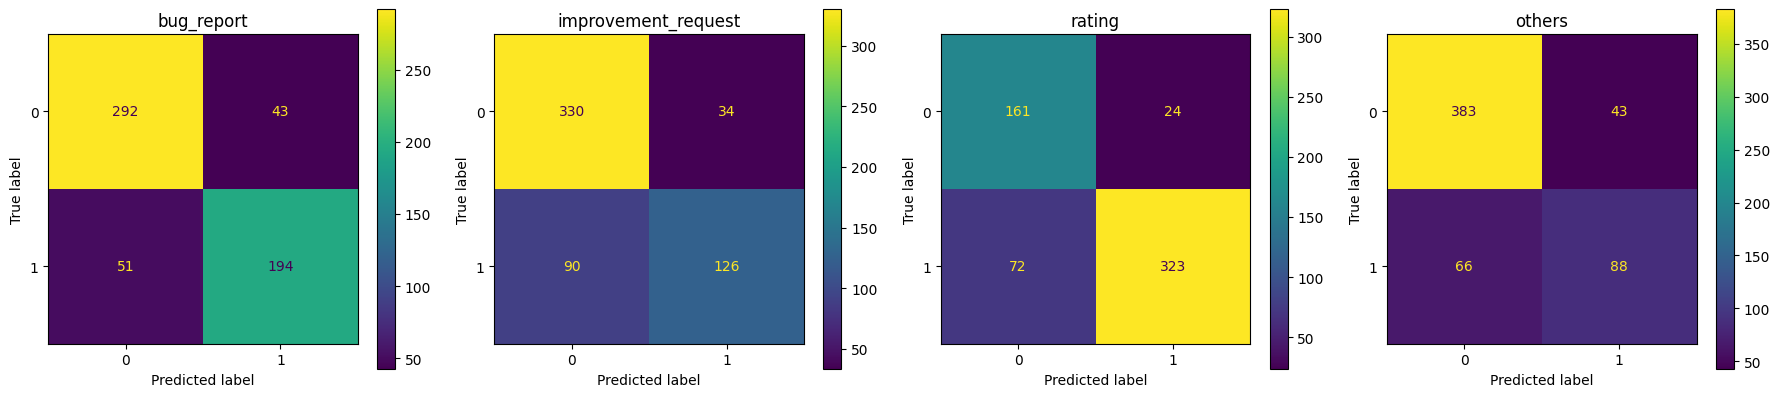

In [33]:
label_cols = ['bug_report', 'improvement_request', 'rating', 'others']
plot_confusion_matrices(model, test_loader, threshold=0.5, label_names=label_cols)
